<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h1 style='margin:10px 5px'> 
Master Thesis Yannik Haller - Regression Analysis 2
</h1>
</div>

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 
Preparation: load packages, set the appropriate working directory and load the data
</h2>
</div>

In [1]:
# Import required baseline packages
import re
import os
import glob
import time
import calendar
import sys
import pandas as pd
import numpy as np

# Change pandas' setting to print out long strings
pd.options.display.max_colwidth = 200

# Plotting tools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# Set global parameters for plotting
import matplotlib.pylab as pylab
params = {'legend.fontsize': 10,
          'figure.figsize': (8, 6),
          'axes.labelsize': 14,
          'axes.titlesize': 16,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10}
pylab.rcParams.update(params)

# Regression and smoothing tools
import statsmodels.api as sm
import statsmodels.stats.diagnostic as ssd
from stargazer.stargazer import Stargazer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold

# Disable warnings
import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)
warnings.filterwarnings("ignore", category = FutureWarning)
pd.set_option('mode.chained_assignment',None)

In [2]:
# Set the appropriate working directory
os.chdir('D:\\Dropbox\\MA_data')

In [3]:
# Read in the dataframe containing the (average and total) sentiments the cantons' readerships are exposed to by the newspapers on a daily level
senti_exposure = pd.read_csv("Analysis/senti_exposure_by_topic.csv", index_col = 0)
# Transform publication_date into a daily date type
senti_exposure.publication_date = pd.to_datetime(senti_exposure.publication_date, yearfirst = True).astype('datetime64[D]')
# Rename several columns as desired
senti_exposure.rename(columns = {'new_conf_pm': 'dcases_pm', 'new_deaths_pm': 'ddeaths_pm', '7d_avg_conf_pm': '7d_avg_dcases_pm', '7d_avg_deaths_pm': '7d_avg_ddeaths_pm', 'stridx': 'KOFSPI'}, inplace = True)
# Take a look at the dataframe
senti_exposure

,publication_date,canton,days_elapsed,year,month,week,weekday,KOFSPI,new_conf,new_deaths,...,tot_Blob_polarity_sports,tot_Vader_polarity_adj_tourism,tot_Vader_polarity_adj_2_tourism,tot_Blob_polarity_tourism,tot_Vader_polarity_adj_tragedies_crimes,tot_Vader_polarity_adj_2_tragedies_crimes,tot_Blob_polarity_tragedies_crimes,tot_Vader_polarity_adj_transportation,tot_Vader_polarity_adj_2_transportation,tot_Blob_polarity_transportation
0,2019-01-01,AG,0,2019,1,0,2,0.0,0.0,0.0,...,5.090300,3.591609,3.339084,1.780409,-3.958509,-3.858086,-6.088240,NaN,NaN,NaN
1,2019-01-02,AG,1,2019,1,0,3,0.0,0.0,0.0,...,6.541127,3.561153,3.283226,2.673688,-3.231048,-3.046774,-2.030495,NaN,NaN,NaN
2,2019-01-03,AG,2,2019,1,0,4,0.0,0.0,0.0,...,4.591702,3.074624,2.827554,2.725723,-7.479535,-7.047246,-5.115048,NaN,NaN,NaN
3,2019-01-04,AG,3,2019,1,0,5,0.0,0.0,0.0,...,6.704284,2.796959,2.596201,3.032581,-5.066425,-4.710205,-4.872170,0.270229,0.251229,0.015164
4,2019-01-05,AG,4,2019,1,0,6,0.0,0.0,0.0,...,5.915830,0.389317,0.361944,-0.126518,-1.979819,-1.840618,-1.831873,0.300774,0.279627,-1.708167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19261,2021-01-18,ZH,736,2021,1,3,1,75.0,210.0,8.0,...,6.205472,3.075791,2.393691,2.023425,-5.492244,-4.795672,-1.306148,-1.623621,-1.509465,0.002693
19262,2021-01-19,ZH,737,2021,1,3,2,75.0,426.0,15.0,...,3.858448,2.718617,2.026134,2.165765,-3.185923,-3.012793,-2.428060,-1.015020,-0.943654,0.000000
19263,2021-01-20,ZH,738,2021,1,3,3,75.0,454.0,8.0,...,2.978518,2.834349,2.264153,2.391853,-2.534243,-2.363485,-3.144802,1.329377,1.235909,0.000000
19264,2021-01-21,ZH,739,2021,1,3,4,75.0,316.0,7.0,...,3.777056,2.103175,1.726089,1.426748,-2.740384,-2.582821,-0.043509,0.487807,0.453509,-2.001956


In [4]:
# Take a look at the size of the prepared data
sys.getsizeof(senti_exposure)

18553182

In [5]:
# Take a look at some information concerning the articles dataframe
senti_exposure.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19266 entries, 0 to 19265
Columns: 113 entries, publication_date to tot_Blob_polarity_transportation
dtypes: datetime64[ns](1), float64(105), int64(6), object(1)
memory usage: 16.8+ MB


<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 
1. Prepare the dataframe for the regression analysis
</h2>
</div>

In [6]:
#### Create Lagged Variables
### For the columns new_conf_pm & 7d_avg_conf_pm we create variables lagged by the average incubation period of covid-19 plus assumed average time from illness to reporting (i.e. approximately 8 days)
### For the columns new_deaths_pm & 7d_avg_deaths_pm we create variables lagged by the average incubation time of covid-19 plus estimated average time from illness onset to death (i.e. approximately 26 days)


## Define functions to get the values lagged by 6 days for the metrics of interest
# Daily confirmed covid cases
def eight_day_lag_new_cases(data):
    '''
    Takes the senti_exposure DataFrame from above and adds a column containing the daily confirmed covid cases lagged by 8 days
    '''
    data['dcases_pm_lagged'] = np.array(data['dcases_pm'].shift(-8))
    return data
# Daily covid deaths
def twentysix_day_lag_new_deaths(data):
    '''
    Takes the senti_exposure DataFrame from above and adds a column containing the daily covid deaths lagged by 26 days
    '''
    data['ddeaths_pm_lagged'] = np.array(data['ddeaths_pm'].shift(-26))
    return data
# 7-day average of daily confirmed covid cases
def eight_day_lag_7d_avg_new_cases(data):
    '''
    Takes the senti_exposure DataFrame from above and adds a column containing the 7-day average of daily confirmed covid cases lagged by 8 days
    '''
    data['7d_avg_dcases_pm_lagged'] = np.array(data['7d_avg_dcases_pm'].shift(-8))
    return data
# 7-day average of daily covid deaths
def twentysix_day_lag_7d_avg_new_deaths(data):
    '''
    Takes the senti_exposure DataFrame created above and adds a column containing the 7-day average of daily covid deaths lagged by 26 days
    '''
    data['7d_avg_ddeaths_pm_lagged'] = np.array(data['7d_avg_ddeaths_pm'].shift(-26))
    return data
## Apply the previously defined functions for each canton separately
# Daily confirmed covid cases
senti_exposure = senti_exposure.groupby(['canton']).apply(eight_day_lag_new_cases)
# Daily covid deaths
senti_exposure = senti_exposure.groupby(['canton']).apply(twentysix_day_lag_new_deaths)
# 7-day average of daily confirmed covid cases
senti_exposure = senti_exposure.groupby(['canton']).apply(eight_day_lag_7d_avg_new_cases)
# 7-day average of daily covid deaths
senti_exposure = senti_exposure.groupby(['canton']).apply(twentysix_day_lag_7d_avg_new_deaths)

## Take a look at the resulting dataframe
senti_exposure

,publication_date,canton,days_elapsed,year,month,week,weekday,KOFSPI,new_conf,new_deaths,...,tot_Vader_polarity_adj_tragedies_crimes,tot_Vader_polarity_adj_2_tragedies_crimes,tot_Blob_polarity_tragedies_crimes,tot_Vader_polarity_adj_transportation,tot_Vader_polarity_adj_2_transportation,tot_Blob_polarity_transportation,dcases_pm_lagged,ddeaths_pm_lagged,7d_avg_dcases_pm_lagged,7d_avg_ddeaths_pm_lagged
0,2019-01-01,AG,0,2019,1,0,2,0.0,0.0,0.0,...,-3.958509,-3.858086,-6.088240,NaN,NaN,NaN,0.0,0.0,0.0,0.0
1,2019-01-02,AG,1,2019,1,0,3,0.0,0.0,0.0,...,-3.231048,-3.046774,-2.030495,NaN,NaN,NaN,0.0,0.0,0.0,0.0
2,2019-01-03,AG,2,2019,1,0,4,0.0,0.0,0.0,...,-7.479535,-7.047246,-5.115048,NaN,NaN,NaN,0.0,0.0,0.0,0.0
3,2019-01-04,AG,3,2019,1,0,5,0.0,0.0,0.0,...,-5.066425,-4.710205,-4.872170,0.270229,0.251229,0.015164,0.0,0.0,0.0,0.0
4,2019-01-05,AG,4,2019,1,0,6,0.0,0.0,0.0,...,-1.979819,-1.840618,-1.831873,0.300774,0.279627,-1.708167,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19261,2021-01-18,ZH,736,2021,1,3,1,75.0,210.0,8.0,...,-5.492244,-4.795672,-1.306148,-1.623621,-1.509465,0.002693,NaN,NaN,NaN,NaN
19262,2021-01-19,ZH,737,2021,1,3,2,75.0,426.0,15.0,...,-3.185923,-3.012793,-2.428060,-1.015020,-0.943654,0.000000,NaN,NaN,NaN,NaN
19263,2021-01-20,ZH,738,2021,1,3,3,75.0,454.0,8.0,...,-2.534243,-2.363485,-3.144802,1.329377,1.235909,0.000000,NaN,NaN,NaN,NaN
19264,2021-01-21,ZH,739,2021,1,3,4,75.0,316.0,7.0,...,-2.740384,-2.582821,-0.043509,0.487807,0.453509,-2.001956,NaN,NaN,NaN,NaN


In [7]:
# Check if everthing worked as desired
senti_exposure.iloc[730:745, [0,1,12,13,14,15,113,114,115,116]]

,publication_date,canton,dcases_pm,ddeaths_pm,7d_avg_dcases_pm,7d_avg_ddeaths_pm,dcases_pm_lagged,ddeaths_pm_lagged,7d_avg_dcases_pm_lagged,7d_avg_ddeaths_pm_lagged
730,2021-01-11,AG,299.807119,4.430647,368.376657,9.072277,290.945825,NaN,261.619161,NaN
731,2021-01-12,AG,407.619531,7.384412,341.792775,8.861294,301.284002,NaN,249.593119,NaN
732,2021-01-13,AG,270.269472,4.430647,309.090380,8.228345,261.408178,NaN,253.812783,NaN
733,2021-01-14,AG,385.466296,4.430647,312.888077,7.173429,NaN,NaN,NaN,NaN
734,2021-01-15,AG,231.870531,8.861294,295.587455,7.384412,NaN,NaN,NaN,NaN
735,2021-01-17,AG,104.858648,2.953765,276.387985,5.696546,NaN,NaN,NaN,NaN
736,2021-01-18,AG,255.500648,4.430647,270.058489,5.696546,NaN,NaN,NaN,NaN
737,2021-01-19,AG,327.867884,5.907529,258.665396,5.485563,NaN,NaN,NaN,NaN
738,2021-01-20,AG,290.945825,5.907529,261.619161,5.696546,NaN,NaN,NaN,NaN
739,2021-01-21,AG,301.284002,7.384412,249.593119,6.118513,NaN,NaN,NaN,NaN


In [8]:
# Check out how many missing values we have in each variable
senti_exposure.isna().sum()[np.arange(21,66,3)]

avg_Vader_polarity_adj_2_COVID                     5092
avg_Vader_polarity_adj_2_culture                    113
avg_Vader_polarity_adj_2_economy_international      831
avg_Vader_polarity_adj_2_economy_national           175
avg_Vader_polarity_adj_2_inconsequential            116
avg_Vader_polarity_adj_2_international_news         455
avg_Vader_polarity_adj_2_law_order                  202
avg_Vader_polarity_adj_2_politics_international     220
avg_Vader_polarity_adj_2_politics_national          198
avg_Vader_polarity_adj_2_public_affairs             575
avg_Vader_polarity_adj_2_public_health              721
avg_Vader_polarity_adj_2_sports                     146
avg_Vader_polarity_adj_2_tourism                    537
avg_Vader_polarity_adj_2_tragedies_crimes           289
avg_Vader_polarity_adj_2_transportation            6524
dtype: int64

In [9]:
# Check how many observations would remain if we remove every entry containing any missing values
senti_exposure.dropna().shape[0]

8572

In [10]:
# Check for which cantons no observations at all would be left after dropping every entry containing any missing values
missing_cantons = []
[missing_cantons.append(canton) for canton in senti_exposure['canton'].unique() if canton not in senti_exposure.dropna()['canton'].unique()]
missing_cantons

[]

In [11]:
# Take a look at the different cantons for which missing values in the columns containing the (overall) daily average or total polarity exposed to the cantonal readership occur
np.unique(senti_exposure.loc[senti_exposure['avg_Vader_polarity_adj_2'].isna(), 'canton'], return_counts = True)
# Note: the only striking observation is that for Ticino we have 24 out of the 741 days covered by the considered timeframe at which no articles are exposed to the residing readership.
## Except that, there does not seem to be any systematic pattern.

(array(['AG', 'AI', 'AR', 'BL', 'BS', 'GL', 'GR', 'JU', 'LU', 'NE', 'NW',
        'OW', 'SG', 'SH', 'SO', 'SZ', 'TG', 'TI', 'UR', 'ZG', 'ZH'],
       dtype=object),
 array([ 3,  6,  4,  4,  4,  4,  4,  6,  3,  6,  3,  3,  4,  4,  4,  3,  4,
        24,  3,  3,  4], dtype=int64))

In [12]:
# Remove entries with missing values in the columns containing the (overall) daily average or total polarity exposed to the cantonal readership
senti_exposure = senti_exposure.loc[np.logical_not(senti_exposure['avg_Vader_polarity_adj_2'].isna())]

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 
2. Main regressions: Effect of the exposed polarity & KOFSPI on the development of confirmed covid cases per million population (RM2)
</h2>
</div>

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> 
2.1.1 Effect of the overall daily AVERAGE polarity exposed to the cantonal readership on LAGGED daily covid cases per million population (RM2A & RM2B with AEP)
</h3>
</div>

In [13]:
### Create a dataframe which suits the structure required in this regression model
# Remove entries with missing values in the columns containing the lagged covid cases and store it into the variable senti_exposure_reg
senti_exposure_reg = senti_exposure.loc[np.logical_not(senti_exposure['dcases_pm_lagged'].isna())].copy()

## Add the numerical variables of interest
cols = senti_exposure_reg.columns[[12,14]].tolist()                 # contemporaneous covid metrics
[cols.append(col) for col in senti_exposure_reg.columns[[113,115]]] # lagged covid metrics
[cols.append(col) for col in senti_exposure_reg.columns[[16,7]]]    # canton population & covid stringency index (KOFSPI)
[cols.append(col) for col in senti_exposure_reg.columns[17:20]]     # overall daily average polarity scores exposed to the cantonal readership
[cols.append(col) for col in senti_exposure_reg.columns[65:68]]     # overall daily total polarity scores exposed to the cantonal readership
reg_df_base = senti_exposure_reg[cols].copy()
#reg_df_base.dropna(inplace = True)

## Add the categorical variables
### Note: We use one hot encoding to transform each categorical feature into an indicator variables for each category. To prevent multicollinearity issues, 
### we drop the first category of each discrete variable as a reference class

# Elapsed Days
reg_df_base = reg_df_base.merge(pd.get_dummies(senti_exposure_reg['publication_date'], drop_first = True, prefix = 'date'),
                                how = 'inner', left_index = True, right_index = True, validate = "1:1") # Reference class: 01-01-2019
# Canton
reg_df_base = reg_df_base.merge(pd.get_dummies(senti_exposure_reg['canton'], drop_first = True, prefix = 'canton'),
                                how = 'inner', left_index = True, right_index = True, validate = "1:1") # Reference class: AG

# Take a look at the created dataframe
reg_df_base

,dcases_pm,7d_avg_dcases_pm,dcases_pm_lagged,7d_avg_dcases_pm_lagged,canton_population,KOFSPI,avg_Vader_polarity_adj,avg_Vader_polarity_adj_2,avg_Blob_polarity,tot_Vader_polarity_adj,...,canton_SH,canton_SO,canton_SZ,canton_TG,canton_TI,canton_UR,canton_VD,canton_VS,canton_ZG,canton_ZH
0,0.000000,0.000000,0.000000,0.000000,677102,0.0,0.587978,0.539291,0.223470,21.728777,...,0,0,0,0,0,0,0,0,0,0
1,0.000000,0.000000,0.000000,0.000000,677102,0.0,0.455045,0.389803,0.259653,19.582486,...,0,0,0,0,0,0,0,0,0,0
2,0.000000,0.000000,0.000000,0.000000,677102,0.0,0.665172,0.613137,0.434507,37.590222,...,0,0,0,0,0,0,0,0,0,0
3,0.000000,0.000000,0.000000,0.000000,677102,0.0,0.661837,0.601875,0.406722,36.833894,...,0,0,0,0,0,0,0,0,0,0
4,0.000000,0.000000,0.000000,0.000000,677102,0.0,0.613304,0.560210,0.238760,27.850658,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19253,341.555374,429.591934,139.005094,251.533028,1510736,70.0,0.518781,0.209966,0.258640,24.620132,...,0,0,0,0,0,0,0,0,0,1
19254,153.567533,405.384244,281.981763,236.308660,1510736,70.0,0.516129,0.209496,0.286945,30.307369,...,0,0,0,0,0,0,0,0,0,1
19255,197.254848,381.933045,300.515775,230.351299,1510736,70.0,0.604419,0.315976,0.365962,29.871143,...,0,0,0,0,0,0,0,0,0,1
19256,388.552335,354.604832,209.169570,220.422364,1510736,70.0,0.732281,0.382564,0.505993,38.026311,...,0,0,0,0,0,0,0,0,0,1


In [14]:
## Get the feature variables to use in the regression
# Create a copy of the baseline dataframe created for this regression analaysis
reg_df = reg_df_base.copy()
# Variables of interest
features = reg_df[['KOFSPI', 'avg_Vader_polarity_adj_2']]
# Control variables
features = features.merge(reg_df[reg_df.columns[12:]], how = 'inner', left_index = True, right_index = True, validate = "1:1")
# Add a constant
features = sm.add_constant(features)

## Get the target variables / labels
# Lagged daily confirmed covid cases
label_1 = reg_df[['dcases_pm_lagged']]

In [15]:
### Estimate the desired linear regression models (using CS & T FE)
## Create the different feature selection sets to use subsequently
# Basic model without any fixed effects
selection_1 = [0,1,2]
# Add time fixed effects
selection_2 = selection_1.copy()
[selection_2.append(num) for num in np.arange(3,735)]   # publication date
# Add cross-sectional fixed effects
selection_3 = selection_2.copy()
[selection_3.append(num) for num in np.arange(735,760)] # cantons 

## OLS model with lagged daily confirmed covid cases as label (without KOFSPI)
model_01 = sm.OLS(label_1, features[features.columns[[selection_3[0]] + selection_3[2:]]]).fit()
## OLS model with lagged daily confirmed covid cases as label
model_02 = sm.OLS(label_1, features[features.columns[selection_3]]).fit()
## WLS model with lagged daily confirmed covid cases as label (without KOFSPI) and observations weighted by the respective canton's population
model_03 = sm.WLS(label_1, features[features.columns[[selection_3[0]] + selection_3[2:]]], weights = reg_df['canton_population']).fit()
## WLS model with lagged daily confirmed covid cases as label and observations weighted by the respective canton's population
model_04 = sm.WLS(label_1, features[features.columns[selection_3]], weights = reg_df['canton_population']).fit()

In [16]:
# Perform Breusch-Pagan test for heteroskedasticity
bp_01 = ssd.het_breuschpagan(model_01.resid, features[features.columns[selection_3]])
bp_02 = ssd.het_breuschpagan(model_02.resid, features[features.columns[selection_3]])
bp_03 = ssd.het_breuschpagan(model_03.resid, features[features.columns[selection_3]])
bp_04 = ssd.het_breuschpagan(model_04.resid, features[features.columns[selection_3]])
print(bp_01)
print(bp_02)
print(bp_03)
print(bp_04)

# As we observe that H0 (i.e. Homoskedasticity) can be rejected with very high significance (as the p-values for the lagrange multiplier test as well as for the f-statistic are very low), 
# we decide to control for heteroskedastic standard errors in the subsequent regressions

(5413.230571515716, 0.0, 9.582777289469323, 0.0)
(5388.844251450904, 0.0, 9.52245912340258, 0.0)
(5755.75936000896, 0.0, 10.453553969096827, 0.0)
(5698.39841467646, 0.0, 10.304594120579585, 0.0)


In [17]:
## OLS model with lagged daily confirmed covid cases as label (without KOFSPI)
model_01 = sm.OLS(label_1, features[features.columns[[selection_3[0]] + selection_3[2:]]]).fit(cov_type = 'HC3')
## OLS model with lagged daily confirmed covid cases as label
model_02 = sm.OLS(label_1, features[features.columns[selection_3]]).fit(cov_type = 'HC3')
## WLS model with lagged daily confirmed covid cases as label (without KOFSPI) and observations weighted by the respective canton's population
model_03 = sm.WLS(label_1, features[features.columns[[selection_3[0]] + selection_3[2:]]], weights = reg_df['canton_population']).fit(cov_type = 'HC3')
## WLS model with lagged daily confirmed covid cases as label and observations weighted by the respective canton's population
model_04 = sm.WLS(label_1, features[features.columns[selection_3]], weights = reg_df['canton_population']).fit(cov_type = 'HC3')

In [18]:
# Compare the results of the estimated models
stargazer = Stargazer([model_01, model_02, model_03, model_04])
stargazer.title('Effect of Average Exposed Polarity & KOFSPI on Lagged Daily Confirmed Covid-19 Cases per Million (Models with CS & T FE)')
stargazer.custom_columns(['RM2A with OLS', 'RM2B with OLS', 'RM2A with WLS', 'RM2B with WLS'], [1, 1, 1, 1])
stargazer.show_model_numbers(False)
stargazer.significant_digits(5)
coef_ordered = features.columns[selection_1].tolist()
stargazer.covariate_order(coef_ordered)
stargazer.show_degrees_of_freedom(False)
stargazer
#stargazer.render_latex()

# Note: Reference classes
## Canton:      AG
## Day:         2019-01-01

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> 
2.1.2 Effect of the daily AVERAGE polarity exposed to the cantonal readership by media section on LAGGED daily covid cases per million population (RM2C with AEP)
</h3>
</div>

In [19]:
### Create a dataframe which suits the structure required in this regression model
# Remove all entries with missing values in the senti_exposure dataframe and store it into the variable senti_exposure_sparse
senti_exposure_sparse = senti_exposure.dropna().copy()

## Add the numerical variables of interest
cols = senti_exposure_sparse.columns[[12,14]].tolist()                 # contemporaneous covid metrics
[cols.append(col) for col in senti_exposure_sparse.columns[[113,115]]] # lagged covid metrics
[cols.append(col) for col in senti_exposure_sparse.columns[[16,7]]]    # canton population & covid stringency index (KOFSPI)
[cols.append(col) for col in senti_exposure_sparse.columns[20:65]]     # daily average polarity scores exposed to the cantonal readership by topic (Media section)
[cols.append(col) for col in senti_exposure_sparse.columns[68:113]]    # daily total polarity scores exposed to the cantonal readership by topic (Media section)
reg_df_base_by_topic = senti_exposure_sparse[cols].copy()

## Add the categorical variables
### Note: We use one hot encoding to transform each categorical feature into an indicator variables for each category. To prevent multicollinearity issues, 
### we drop the first category of each discrete variable as a reference class

# Elapsed Days
reg_df_base_by_topic = reg_df_base_by_topic.merge(pd.get_dummies(senti_exposure_sparse['publication_date'], drop_first = True, prefix = 'date'),
                                                  how = 'inner', left_index = True, right_index = True, validate = "1:1") # Reference class: 01-01-2019
# Canton
reg_df_base_by_topic = reg_df_base_by_topic.merge(pd.get_dummies(senti_exposure_sparse['canton'], drop_first = True, prefix = 'canton'),
                                                  how = 'inner', left_index = True, right_index = True, validate = "1:1") # Reference class: AG

# Take a look at the created dataframe
reg_df_base_by_topic

,dcases_pm,7d_avg_dcases_pm,dcases_pm_lagged,7d_avg_dcases_pm_lagged,canton_population,KOFSPI,avg_Vader_polarity_adj_COVID,avg_Vader_polarity_adj_2_COVID,avg_Blob_polarity_COVID,avg_Vader_polarity_adj_culture,...,canton_SH,canton_SO,canton_SZ,canton_TG,canton_TI,canton_UR,canton_VD,canton_VS,canton_ZG,canton_ZH
4,0.000000,0.000000,0.000000,0.000000,677102,0.000000,1.153457,1.072358,0.424587,1.096916,...,0,0,0,0,0,0,0,0,0,0
6,0.000000,0.000000,0.000000,0.000000,677102,0.000000,-0.796843,-1.254087,-0.578558,1.304127,...,0,0,0,0,0,0,0,0,0,0
7,0.000000,0.000000,0.000000,0.000000,677102,0.000000,-0.847788,-0.788180,0.000000,1.148263,...,0,0,0,0,0,0,0,0,0,0
8,0.000000,0.000000,0.000000,0.000000,677102,0.000000,-0.415311,-0.386110,-0.346601,1.047521,...,0,0,0,0,0,0,0,0,0,0
10,0.000000,0.000000,0.000000,0.000000,677102,0.000000,-0.179045,-0.338404,-0.558763,1.063346,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19233,538.148293,549.968454,307.135065,482.451694,1510736,59.166668,0.562663,-0.712643,0.371513,1.099620,...,0,0,0,0,0,0,0,0,0,1
19235,312.430497,540.985132,595.736118,457.109269,1510736,59.166668,0.342749,-1.074030,0.229597,1.092179,...,0,0,0,0,0,0,0,0,0,1
19236,646.704653,538.621100,599.707692,448.976998,1510736,70.000000,0.557997,-0.816886,0.204022,1.307030,...,0,0,0,0,0,0,0,0,0,1
19237,798.286398,564.152648,364.060961,441.506656,1510736,70.000000,0.465103,-0.681940,0.218487,1.000686,...,0,0,0,0,0,0,0,0,0,1


In [20]:
## Get the feature variables to use in the regression
# Create a copy of the baseline dataframe created for this regression analaysis
reg_df = reg_df_base_by_topic.copy()
# Variables of interest (KOFSPI and topic specific average polarity exposed to the cantonal readership)
features = reg_df[['KOFSPI']]
features = features.merge(reg_df[reg_df.columns[[np.arange(7,52,3)]]], how = 'inner', left_index = True, right_index = True, validate = "1:1")
# Control variables
features = features.merge(reg_df[reg_df.columns[96:]], how = 'inner', left_index = True, right_index = True, validate = "1:1")
# Add a constant
features = sm.add_constant(features)

## Get the target variables / labels
# Lagged daily confirmed covid cases
label = reg_df[['dcases_pm_lagged']]

In [21]:
### Estimate the desired linear regression models (using CS & T FE)
## Create the different feature selection sets to use subsequently
# Basic model without any fixed effects
selection_1 = list(np.arange(0,17))
# Add time fixed effects
selection_2 = selection_1.copy()
[selection_2.append(num) for num in np.arange(17,666)]  # publication date
# Add cross-sectional fixed effects
selection_3 = selection_2.copy()
[selection_3.append(num) for num in np.arange(666,691)] # cantons

## WLS model with lagged daily confirmed covid cases as label and observations weighted by the respective canton's population
model_01 = sm.WLS(label, features[features.columns[selection_3]], weights = reg_df['canton_population']).fit(cov_type = 'HC1')

In [22]:
# Compare the results of the estimated models
stargazer = Stargazer([model_01])
stargazer.title('Effect of Average Exposed Polarity by Media Section & KOFSPI on Lagged Daily Confirmed Covid-19 Cases per Million (Models with CS & T FE)')
stargazer.custom_columns(['RM2C wit AEP'], [1])
stargazer.show_model_numbers(False)
stargazer.significant_digits(5)
coef_ordered = features.columns[selection_1].tolist()
stargazer.covariate_order(coef_ordered)
stargazer.show_degrees_of_freedom(False)
stargazer
#stargazer.render_latex()

# Note: Reference classes
## Canton:      AG
## Day:         2019-01-01

C:\Users\Hallk\.conda\envs\Master_Thesis_env\lib\site-packages\statsmodels\base\model.py:1834: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 690, but rank is 677
  'rank is %d' % (J, J_), ValueWarning)


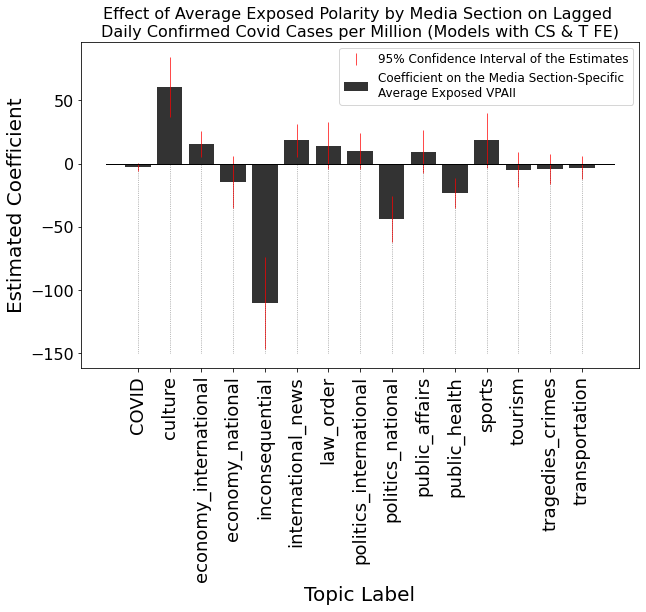

In [23]:
# Define a function to visualize the media section-specific estimated coefficients
topic_coeff = model_01.params.values[selection_1][2:]
topic_se    = model_01.bse.values[selection_1][2:]
topic_label = []
[topic_label.append(label[25:]) for label in model_01.params.index[selection_1][2:]]

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
x_pos = np.arange(len(topic_coeff))
ax.bar(x_pos, topic_coeff, align = 'center', color = 'black', alpha = 0.8, yerr = 1.96*topic_se, ecolor = 'red', error_kw = {'lw': 0.7, 'label': '95% Confidence Interval of the Estimates'}, 
      label = 'Coefficient on the Media Section-Specific\nAverage Exposed VPAII')
ax.plot([min(x_pos)-1,max(x_pos)+1], [0,0], color = 'black', linewidth = 1)
for i in range(len(x_pos)):
    plt.vlines(x_pos[i], -150, min(topic_coeff[i],0), colors = 'black', linestyles = 'dotted', alpha = 0.5, linewidth = 0.7)
ax.set_xticks(x_pos)
ax.set_xticklabels(topic_label, rotation = 90, ha = 'center', fontsize = 18)
ax.tick_params(axis = 'y', labelsize = 16)
ax.set_title('Effect of Average Exposed Polarity by Media Section on Lagged \nDaily Confirmed Covid Cases per Million (Models with CS & T FE)')
ax.set_xlabel('Topic Label', fontsize = 20)
ax.set_ylabel('Estimated Coefficient', fontsize = 20)
# Display the plot
ax.legend(loc = 'best', fontsize = 12)
plt.show()

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> 
2.2.1 Effect of the overall daily TOTAL polarity exposed to the cantonal readership on LAGGED daily covid cases per million population (RM2A & RM2B with TEP)
</h3>
</div>

In [24]:
## Get the feature variables to use in the regression
# Create a copy of the baseline dataframe created for this regression analaysis
reg_df = reg_df_base.copy()
# Variables of interest
features = reg_df[['KOFSPI', 'tot_Vader_polarity_adj_2']]
# Control variables
features = features.merge(reg_df[reg_df.columns[12:]], how = 'inner', left_index = True, right_index = True, validate = "1:1")
# Add a constant
features = sm.add_constant(features)

## Get the target variables / labels
# Lagged daily confirmed covid cases
label_1 = reg_df[['dcases_pm_lagged']]
# Lagged 7-day average of daily confirmed covid cases
label_2 = reg_df[['7d_avg_dcases_pm_lagged']]

In [25]:
### Estimate the desired linear regression models (using CS & T FE)
## Create the different feature selection sets to use subsequently
# Basic model without any fixed effects
selection_1 = [0,1,2]
# Add time fixed effects
selection_2 = selection_1.copy()
[selection_2.append(num) for num in np.arange(3,735)]   # publication date
# Add cross-sectional fixed effects
selection_3 = selection_2.copy()
[selection_3.append(num) for num in np.arange(735,760)] # cantons 

## OLS model with lagged daily confirmed covid cases as label (without KOFSPI)
model_01 = sm.OLS(label_1, features[features.columns[[selection_3[0]] + selection_3[2:]]]).fit()
## OLS model with lagged daily confirmed covid cases as label
model_02 = sm.OLS(label_1, features[features.columns[selection_3]]).fit()
## WLS model with lagged daily confirmed covid cases as label (without KOFSPI) and observations weighted by the respective canton's population
model_03 = sm.WLS(label_1, features[features.columns[[selection_3[0]] + selection_3[2:]]], weights = reg_df['canton_population']).fit()
## WLS model with lagged daily confirmed covid cases as label and observations weighted by the respective canton's population
model_04 = sm.WLS(label_1, features[features.columns[selection_3]], weights = reg_df['canton_population']).fit()

In [26]:
# Perform Breusch-Pagan test for heteroskedasticity
bp_01 = ssd.het_breuschpagan(model_01.resid, features[features.columns[selection_3]])
bp_02 = ssd.het_breuschpagan(model_02.resid, features[features.columns[selection_3]])
bp_03 = ssd.het_breuschpagan(model_03.resid, features[features.columns[selection_3]])
bp_04 = ssd.het_breuschpagan(model_04.resid, features[features.columns[selection_3]])
print(bp_01)
print(bp_02)
print(bp_03)
print(bp_04)

(5415.8210388608995, 0.0, 9.589197428767939, 0.0)
(5390.375715706524, 0.0, 9.526240730198612, 0.0)
(5761.782085848596, 0.0, 10.469269443094364, 0.0)
(5702.873310803691, 0.0, 10.316168540868386, 0.0)


In [27]:
# As we observe that H0 (i.e. Homoskedasticity) can be rejected with very high significance (as the p-values for the lagrange multiplier test as well as for the f-statistic are very low), 
# we decide to control for heteroskedastic standard errors in the subsequent regressions
### As we observe heterskedasticity we repeat the model estimation with heteroskedasticity robust standard errors
## OLS model with lagged daily confirmed covid cases as label (without KOFSPI)
model_01 = sm.OLS(label_1, features[features.columns[[selection_3[0]] + selection_3[2:]]]).fit(cov_type = 'HC3')
## OLS model with lagged daily confirmed covid cases as label
model_02 = sm.OLS(label_1, features[features.columns[selection_3]]).fit(cov_type = 'HC3')
## WLS model with lagged daily confirmed covid cases as label (without KOFSPI) and observations weighted by the respective canton's population
model_03 = sm.WLS(label_1, features[features.columns[[selection_3[0]] + selection_3[2:]]], weights = reg_df['canton_population']).fit(cov_type = 'HC3')
## WLS model with lagged daily confirmed covid cases as label and observations weighted by the respective canton's population
model_04 = sm.WLS(label_1, features[features.columns[selection_3]], weights = reg_df['canton_population']).fit(cov_type = 'HC3')

In [28]:
# Compare the results of the estimated models
stargazer = Stargazer([model_01, model_02, model_03, model_04])
stargazer.title('Effect of Total Exposed Polarity & KOFSPI on Lagged Daily Confirmed Covid-19 Cases per Million (Models with CS & T FE)')
stargazer.custom_columns(['RM2A with OLS', 'RM2B with OLS', 'RM2A with WLS', 'RM2B with WLS'], [1, 1, 1, 1])
stargazer.show_model_numbers(False)
stargazer.significant_digits(5)
coef_ordered = features.columns[selection_1].tolist()
stargazer.covariate_order(coef_ordered)
stargazer.show_degrees_of_freedom(False)
stargazer
#stargazer.render_latex()

# Note: Reference classes
## Canton:      AG
## Day:         2019-01-01

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> 
2.2.2 Effect of the daily TOTAL polarity exposed to the cantonal readership by media section on LAGGED daily covid cases per million population (RM2C with TEP)
</h3>
</div>

In [29]:
## Get the feature variables to use in the regression
# Create a copy of the baseline dataframe created for this regression analaysis
reg_df = reg_df_base_by_topic.copy()
# Variables of interest (KOFSPI and topic specific total polarity exposed to the cantonal readership)
features = reg_df[['KOFSPI']]
features = features.merge(reg_df[reg_df.columns[[np.arange(52,97,3)]]], how = 'inner', left_index = True, right_index = True, validate = "1:1")
# Control variables
features = features.merge(reg_df[reg_df.columns[96:]], how = 'inner', left_index = True, right_index = True, validate = "1:1")
# Add a constant
features = sm.add_constant(features)

## Get the target variables / labels
# Lagged daily confirmed covid cases
label = reg_df[['dcases_pm_lagged']]

In [30]:
### Estimate the desired linear regression models (using CS & T FE)
## Create the different feature selection sets to use subsequently
# Basic model without any fixed effects
selection_1 = list(np.arange(0,17))
# Add time fixed effects
selection_2 = selection_1.copy()
[selection_2.append(num) for num in np.arange(17,666)]  # date
# Add cross-sectional fixed effects
selection_3 = selection_2.copy()
[selection_3.append(num) for num in np.arange(666,691)] # cantons

## WLS model with lagged daily confirmed covid cases as label and observations weighted by the respective canton's population
model_01 = sm.WLS(label, features[features.columns[selection_3]], weights = reg_df['canton_population']).fit(cov_type = 'HC1')

In [31]:
# Compare the results of the estimated models
stargazer = Stargazer([model_01])
stargazer.title('Effect of Total Exposed Polarity by Topic & KOFSPI on Lagged Daily Confirmed Covid-19 Cases per Million (Models with CS & T FE)')
stargazer.custom_columns(['RM2C wit TEP'], [1])
stargazer.show_model_numbers(False)
stargazer.significant_digits(5)
coef_ordered = features.columns[selection_1].tolist()
stargazer.covariate_order(coef_ordered)
stargazer.show_degrees_of_freedom(False)
stargazer
#stargazer.render_latex()

# Note: Reference classes
## Canton:      AG
## Day:         2019-01-01

C:\Users\Hallk\.conda\envs\Master_Thesis_env\lib\site-packages\statsmodels\base\model.py:1834: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 690, but rank is 676
  'rank is %d' % (J, J_), ValueWarning)


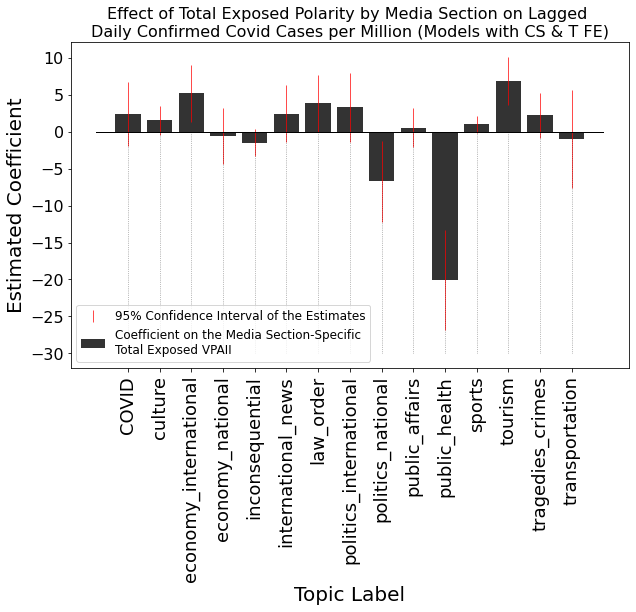

In [32]:
# Define a function to visualize the media section-specific estimated coefficients
topic_coeff = model_01.params.values[selection_1][2:]
topic_se    = model_01.bse.values[selection_1][2:]
topic_label = []
[topic_label.append(label[25:]) for label in model_01.params.index[selection_1][2:]]

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
x_pos = np.arange(len(topic_coeff))
ax.bar(x_pos, topic_coeff, align = 'center', color = 'black', alpha = 0.8, yerr = 1.96*topic_se, ecolor = 'red', error_kw = {'lw': 0.7, 'label': '95% Confidence Interval of the Estimates'}, 
      label = 'Coefficient on the Media Section-Specific\nTotal Exposed VPAII')
ax.plot([min(x_pos)-1,max(x_pos)+1], [0,0], color = 'black', linewidth = 1)
for i in range(len(x_pos)):
    plt.vlines(x_pos[i], -30, min(topic_coeff[i],0), colors = 'black', linestyles = 'dotted', alpha = 0.5, linewidth = 0.7)
ax.set_xticks(x_pos)
ax.set_xticklabels(topic_label, rotation = 90, ha = 'center', fontsize = 18)
ax.tick_params(axis = 'y', labelsize = 16)
ax.set_title('Effect of Total Exposed Polarity by Media Section on Lagged \nDaily Confirmed Covid Cases per Million (Models with CS & T FE)')
ax.set_xlabel('Topic Label', fontsize = 20)
ax.set_ylabel('Estimated Coefficient', fontsize = 20)
# Display the plot
ax.legend(loc = (0.01,0.02), fontsize = 12)
plt.show()

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 
3. Robustness Check 4 (RC4): Using different polarity types to estimate the effect of the Average/Total polarity exposed to the cantonal readership & KOFSPI on LAGGED daily covid cases per million population
</h2>
</div>

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> 
3.1.1 Effect of the overall daily AVERAGE polarity exposed to the cantonal readership on LAGGED daily covid cases per million population (RC4 with AEP)
</h3>
</div>

In [33]:
## Get the feature variables to use in the regression
# Create a copy of the baseline dataframe created for this regression analaysis
reg_df = reg_df_base.copy()
# Variables of interest
features_1 = reg_df[['KOFSPI', 'avg_Vader_polarity_adj_2']]
features_2 = reg_df[['KOFSPI', 'avg_Vader_polarity_adj']]
features_3 = reg_df[['KOFSPI', 'avg_Blob_polarity']]
# Control variables
features_1 = features_1.merge(reg_df[reg_df.columns[12:]], how = 'inner', left_index = True, right_index = True, validate = "1:1")
features_2 = features_2.merge(reg_df[reg_df.columns[12:]], how = 'inner', left_index = True, right_index = True, validate = "1:1")
features_3 = features_3.merge(reg_df[reg_df.columns[12:]], how = 'inner', left_index = True, right_index = True, validate = "1:1")
# Add a constant
features_1 = sm.add_constant(features_1)
features_2 = sm.add_constant(features_2)
features_3 = sm.add_constant(features_3)

## Get the target variables / labels
# Lagged daily confirmed covid cases
label = reg_df[['dcases_pm_lagged']]


### Estimate the desired linear regression models (using CS & T FE)
## Create the different feature selection sets to use subsequently
# Basic model without any fixed effects
selection_1 = [0,1,2]
# Add time fixed effects
selection_2 = selection_1.copy()
[selection_2.append(num) for num in np.arange(3,735)]   # days elapsed
# Add cross-sectional fixed effects
selection_3 = selection_2.copy()
[selection_3.append(num) for num in np.arange(735,760)] # cantons 

## WLS model with lagged daily confirmed covid cases as label and observations weighted by the respective canton's population
# Main regressor: average adjusted Vader polarity 2 exposed to the cantonal readership (baseline model)
model_01 = sm.WLS(label, features_1[features_1.columns[selection_3]], weights = reg_df['canton_population']).fit(cov_type = 'HC3')
## WLS model with lagged daily confirmed covid cases as label and observations weighted by the respective canton's population
# Main regressor: average adjusted Vader polarity exposed to the cantonal readership
model_02 = sm.WLS(label, features_2[features_2.columns[selection_3]], weights = reg_df['canton_population']).fit(cov_type = 'HC3')
## WLS model with lagged daily confirmed covid cases as label and observations weighted by the respective canton's population
# Main regressor: average TextBlob polarity exposed to the cantonal readership
model_03 = sm.WLS(label, features_3[features_3.columns[selection_3]], weights = reg_df['canton_population']).fit(cov_type = 'HC3')

# Compare the results of the estimated models
stargazer = Stargazer([model_01, model_02, model_03])
stargazer.title('Effect of Average Exposed Polarity & KOFSPI on Lagged Daily Confirmed Covid Cases per Million (WLS Models with CS & T FE)')
stargazer.custom_columns(['RM2B wit AEP', 'RC4A wit AEP', 'RC4B wit AEP'], [1, 1, 1])
stargazer.show_model_numbers(False)
stargazer.significant_digits(5)
coef_ordered = features_1.columns[:2].tolist()
[coef_ordered.append(coef) for coef in ['avg_Vader_polarity_adj_2', 'avg_Vader_polarity_adj', 'avg_Blob_polarity']]
stargazer.covariate_order(coef_ordered)
stargazer.show_degrees_of_freedom(False)
stargazer
#stargazer.render_latex()

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> 
3.2 Effect of the TOTAL polarity exposed to the cantonal readership on LAGGED daily covid cases per million population (RC4 with TEP)
</h3>
</div>

In [34]:
## Get the feature variables to use in the regression
# Create a copy of the baseline dataframe created for this regression analaysis
reg_df = reg_df_base.copy()
# Variables of interest
features_1 = reg_df[['KOFSPI', 'tot_Vader_polarity_adj_2']]
features_2 = reg_df[['KOFSPI', 'tot_Vader_polarity_adj']]
features_3 = reg_df[['KOFSPI', 'tot_Blob_polarity']]
# Control variables
features_1 = features_1.merge(reg_df[reg_df.columns[12:]], how = 'inner', left_index = True, right_index = True, validate = "1:1")
features_2 = features_2.merge(reg_df[reg_df.columns[12:]], how = 'inner', left_index = True, right_index = True, validate = "1:1")
features_3 = features_3.merge(reg_df[reg_df.columns[12:]], how = 'inner', left_index = True, right_index = True, validate = "1:1")
# Add a constant
features_1 = sm.add_constant(features_1)
features_2 = sm.add_constant(features_2)
features_3 = sm.add_constant(features_3)

## Get the target variables / labels
# Lagged daily confirmed covid cases
label = reg_df[['dcases_pm_lagged']]


### Estimate the desired linear regression models (using CS & T FE)
## Create the different feature selection sets to use subsequently
# Basic model without any fixed effects
selection_1 = [0,1,2]
# Add time fixed effects
selection_2 = selection_1.copy()
[selection_2.append(num) for num in np.arange(3,735)]   # days elapsed
# Add cross-sectional fixed effects
selection_3 = selection_2.copy()
[selection_3.append(num) for num in np.arange(735,760)] # cantons 

## WLS model with lagged daily confirmed covid cases as label and observations weighted by the respective canton's population
# Main regressor: total adjusted Vader polarity 2 exposed to the cantonal readership (baseline model)
model_01 = sm.WLS(label, features_1[features_1.columns[selection_3]], weights = reg_df['canton_population']).fit(cov_type = 'HC3')
## WLS model with lagged daily confirmed covid cases as label and observations weighted by the respective canton's population
# Main regressor: total adjusted Vader polarity exposed to the cantonal readership
model_02 = sm.WLS(label, features_2[features_2.columns[selection_3]], weights = reg_df['canton_population']).fit(cov_type = 'HC3')
## WLS model with lagged daily confirmed covid cases as label and observations weighted by the respective canton's population
# Main regressor: total TextBlob polarity exposed to the cantonal readership
model_03 = sm.WLS(label, features_3[features_3.columns[selection_3]], weights = reg_df['canton_population']).fit(cov_type = 'HC3')

# Compare the results of the estimated models
stargazer = Stargazer([model_01, model_02, model_03])
stargazer.title('Effect of Total Exposed Polarity & KOFSPI on Lagged Daily Confirmed Covid Cases per Million (WLS Models with CS & T FE)')
stargazer.custom_columns(['RM2B wit TEP', 'RC4A wit TEP', 'RC4B wit TEP'], [1, 1, 1])
stargazer.show_model_numbers(False)
stargazer.significant_digits(5)
coef_ordered = features_1.columns[:2].tolist()
[coef_ordered.append(coef) for coef in ['tot_Vader_polarity_adj_2', 'tot_Vader_polarity_adj', 'tot_Blob_polarity']]
stargazer.covariate_order(coef_ordered)
stargazer.show_degrees_of_freedom(False)
stargazer
#stargazer.render_latex()

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 
4. Robustness Check 5 (RC5): Effect of the Average/Total exposed polarity (VPAII) & KOFSPI on the development of the daily covid deaths per million population
</h2>
</div>

In [35]:
### Create a dataframe which suits the structure required in this regression model
# Remove entries with missing values in the columns containing the lagged covid deaths and store it into the variable senti_exposure_reg
senti_exposure_reg = senti_exposure.loc[np.logical_not(senti_exposure['ddeaths_pm_lagged'].isna())].copy()

## Add the numerical variables of interest
cols = senti_exposure_reg.columns[[13,15]].tolist()                 # contemporaneous covid metrics
[cols.append(col) for col in senti_exposure_reg.columns[[114,116]]] # lagged covid metrics
[cols.append(col) for col in senti_exposure_reg.columns[[16,7]]]    # canton population & covid stringency index (KOFSPI)
[cols.append(col) for col in senti_exposure_reg.columns[17:20]]     # overall daily average polarity scores exposed to the cantonal readership
[cols.append(col) for col in senti_exposure_reg.columns[65:68]]     # overall daily total polarity scores exposed to the cantonal readership
reg_df_base = senti_exposure_reg[cols].copy()
#reg_df_base.dropna(inplace = True)

## Add the categorical variables
### Note: We use one hot encoding to transform each categorical feature into an indicator variables for each category. To prevent multicollinearity issues, 
### we drop the first category of each discrete variable as a reference class

# Elapsed Days
reg_df_base = reg_df_base.merge(pd.get_dummies(senti_exposure_reg['days_elapsed'], drop_first = True, prefix = 'day'),
                                how = 'inner', left_index = True, right_index = True, validate = "1:1") # Reference class: 0
# Canton
reg_df_base = reg_df_base.merge(pd.get_dummies(senti_exposure_reg['canton'], drop_first = True, prefix = 'canton'),
                                how = 'inner', left_index = True, right_index = True, validate = "1:1") # Reference class: AG

# Take a look at the created dataframe
reg_df_base

,ddeaths_pm,7d_avg_ddeaths_pm,ddeaths_pm_lagged,7d_avg_ddeaths_pm_lagged,canton_population,KOFSPI,avg_Vader_polarity_adj,avg_Vader_polarity_adj_2,avg_Blob_polarity,tot_Vader_polarity_adj,...,canton_SH,canton_SO,canton_SZ,canton_TG,canton_TI,canton_UR,canton_VD,canton_VS,canton_ZG,canton_ZH
0,0.000000,0.000000,0.000000,0.000000,677102,0.000000,0.587978,0.539291,0.223470,21.728777,...,0,0,0,0,0,0,0,0,0,0
1,0.000000,0.000000,0.000000,0.000000,677102,0.000000,0.455045,0.389803,0.259653,19.582486,...,0,0,0,0,0,0,0,0,0,0
2,0.000000,0.000000,0.000000,0.000000,677102,0.000000,0.665172,0.613137,0.434507,37.590222,...,0,0,0,0,0,0,0,0,0,0
3,0.000000,0.000000,0.000000,0.000000,677102,0.000000,0.661837,0.601875,0.406722,36.833894,...,0,0,0,0,0,0,0,0,0,0
4,0.000000,0.000000,0.000000,0.000000,677102,0.000000,0.613304,0.560210,0.238760,27.850658,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19234,16.548226,10.969109,4.633503,5.768239,1510736,59.166668,0.690626,0.248246,0.421820,46.170732,...,0,0,0,0,0,0,0,0,0,1
19235,13.238580,11.536477,5.295432,5.579116,1510736,59.166668,0.836821,0.457085,0.587439,41.439524,...,0,0,0,0,0,0,0,0,0,1
19236,13.238580,11.631038,9.928935,6.146484,1510736,70.000000,0.619757,0.183477,0.349771,39.183738,...,0,0,0,0,0,0,0,0,0,1
19237,12.576651,11.820161,5.295432,5.957361,1510736,70.000000,0.619763,0.267873,0.303745,35.639921,...,0,0,0,0,0,0,0,0,0,1


<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> 
4.1 Effect of the overall daily AVERAGE polarity exposed to the cantonal readership on LAGGED daily covid deaths per million population (RC5 with AEP)
</h3>
</div>

In [36]:
## Get the feature variables to use in the regression
# Create a copy of the baseline dataframe created for this regression analaysis
reg_df = reg_df_base.copy()
# Variables of interest
features = reg_df[['KOFSPI', 'avg_Vader_polarity_adj_2']]
# Control variables
features = features.merge(reg_df[reg_df.columns[12:]], how = 'inner', left_index = True, right_index = True, validate = "1:1")
# Add a constant
features = sm.add_constant(features)

## Get the target variables / labels
# Lagged daily confirmed covid cases
label_1 = reg_df[['ddeaths_pm_lagged']]
# Lagged 7-day average of daily confirmed covid cases
label_2 = reg_df[['7d_avg_ddeaths_pm_lagged']]

### Estimate the desired linear regression models (using CS & T FE)
## Create the different feature selection sets to use subsequently
# Basic model without any fixed effects
selection_1 = [0,1,2]
# Add time fixed effects
selection_2 = selection_1.copy()
[selection_2.append(num) for num in np.arange(3,717)]   # days elapsed
# Add cross-sectional fixed effects
selection_3 = selection_2.copy()
[selection_3.append(num) for num in np.arange(717,742)] # cantons 

## WLS model with lagged daily confirmed covid cases as label and observations weighted by the respective canton's population
model_01 = sm.WLS(label_1, features[features.columns[selection_3]], weights = reg_df['canton_population']).fit(cov_type = 'HC3')

# Compare the results of the estimated models
stargazer = Stargazer([model_01])
stargazer.title('Effect of Average Exposed Polarity & KOFSPI on Lagged Daily Covid Deaths per Million (Models with CS & T FE)')
stargazer.custom_columns(['RC5 with AEP'], [1])
stargazer.show_model_numbers(False)
stargazer.significant_digits(5)
coef_ordered = features.columns[selection_1].tolist()
stargazer.covariate_order(coef_ordered)
stargazer.show_degrees_of_freedom(False)
stargazer
#stargazer.render_latex()

# Note: Reference classes
## Canton:      AG
## Day:         2019-01-01

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> 
4.2 Effect of the overall daily TOTAL polarity exposed to the cantonal readership on LAGGED daily covid deaths per million population (RC5 with TEP)
</h3>
</div>

In [37]:
## Get the feature variables to use in the regression
# Create a copy of the baseline dataframe created for this regression analaysis
reg_df = reg_df_base.copy()
# Variables of interest
features = reg_df[['KOFSPI', 'tot_Vader_polarity_adj_2']]
# Control variables
features = features.merge(reg_df[reg_df.columns[12:]], how = 'inner', left_index = True, right_index = True, validate = "1:1")
# Add a constant
features = sm.add_constant(features)

## Get the target variables / labels
# Lagged daily confirmed covid cases
label_1 = reg_df[['ddeaths_pm_lagged']]
# Lagged 7-day average of daily confirmed covid cases
label_2 = reg_df[['7d_avg_ddeaths_pm_lagged']]

### Estimate the desired linear regression models (using CS & T FE)
## Create the different feature selection sets to use subsequently
# Basic model without any fixed effects
selection_1 = [0,1,2]
# Add time fixed effects
selection_2 = selection_1.copy()
[selection_2.append(num) for num in np.arange(3,717)]   # days elapsed
# Add cross-sectional fixed effects
selection_3 = selection_2.copy()
[selection_3.append(num) for num in np.arange(717,742)] # cantons 

## WLS model with lagged daily confirmed covid cases as label and observations weighted by the respective canton's population
model_02 = sm.WLS(label_1, features[features.columns[selection_3]], weights = reg_df['canton_population']).fit(cov_type = 'HC3')

# Compare the results of the estimated models
stargazer = Stargazer([model_02])
stargazer.title('Effect of Total Exposed Polarity & KOFSPI on Lagged Daily Covid Deaths per Million (Models with CS & T FE)')
stargazer.custom_columns(['RC5 with TEP'], [1])
stargazer.show_model_numbers(False)
stargazer.significant_digits(5)
coef_ordered = features.columns[selection_1].tolist()
stargazer.covariate_order(coef_ordered)
stargazer.show_degrees_of_freedom(False)
stargazer
#stargazer.render_latex()

# Note: Reference classes
## Canton:      AG
## Day:         2019-01-01